# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.014415,False,0.342888
1,-1.482450,False,-1.007482
2,-0.124404,False,-0.276289
3,0.603105,False,-0.957997
4,-0.727656,False,-0.948062
...,...,...,...
995,0.268278,True,5.343520
996,0.627485,True,5.952561
997,0.386836,True,5.278551
998,-0.126685,True,4.891181


<Axes: xlabel='v0'>

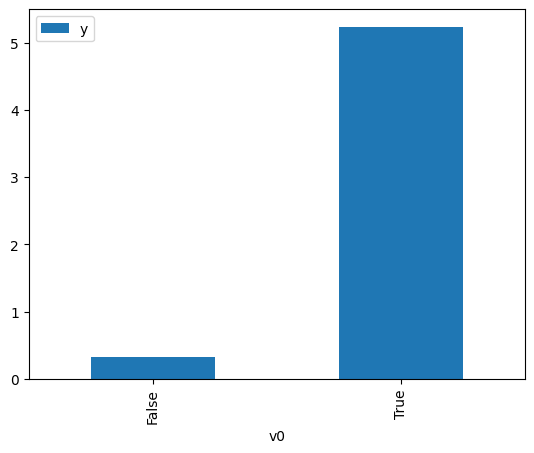

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

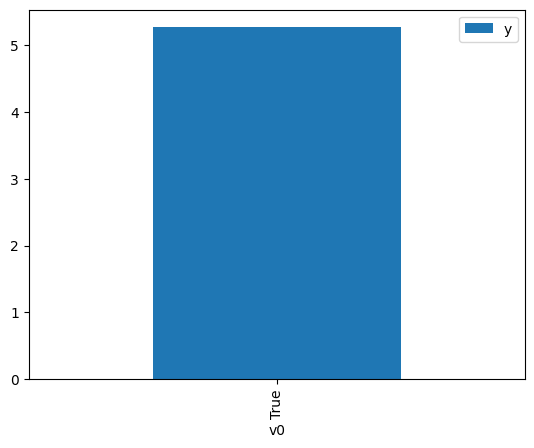

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.237019,False,0.429328,0.433060,2.309147
1,0.212161,False,-1.088310,0.505250,1.979220
2,0.545859,False,0.782776,0.481621,2.076321
3,2.969029,False,4.010701,0.318623,3.138509
4,0.707998,False,-0.715354,0.470164,2.126919
...,...,...,...,...,...
995,0.333450,False,1.252157,0.496659,2.013456
996,0.735678,False,0.668006,0.468211,2.135791
997,-1.003539,False,-2.876310,0.590358,1.693888
998,-1.094670,False,-0.126953,0.596587,1.676201


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.385604,True,4.198492,0.452552,2.209691
1,0.726027,True,6.929670,0.531109,1.882854
2,1.022289,True,7.091965,0.551946,1.811772
3,-0.156933,True,6.465132,0.468647,2.133800
4,0.137361,True,4.197263,0.489454,2.043095
...,...,...,...,...,...
995,-0.649991,True,4.706538,0.434068,2.303788
996,-0.181945,True,3.511025,0.466883,2.141864
997,0.142760,True,5.529220,0.489836,2.041501
998,0.747522,True,7.590880,0.532625,1.877494


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              9142.
Date:                Tue, 05 Dec 2023   Prob (F-statistic):                        0.00
Time:                        17:54:05   Log-Likelihood:                         -1374.3
No. Observations:                1000   AIC:                                      2753.
Df Residuals:                     998   BIC:                                      2762.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3130      0.031     42.767      0.000       1.253       1.373
x2             4.9601      0.045    111.066      0.000       4.872       5.048
==============================================================================
Omnibus:                        3.780   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.633
Skew:                           0.135   Prob(JB):                        0.163
Kurtosis:                       3.120   Cond. No.                         1.61
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""